In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Module 1

In [3]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def naive_circuit():
    """Create a uniform superposition and return the probabilities.

    Returns: 
        array[float]: Probabilities for observing different outcomes.
    """
    for wire in range(n_bits):
        ##################
        # YOUR CODE HERE #
        ##################
        qml.Hadamard(wires = wire)
    return qml.probs(wires=range(n_bits))

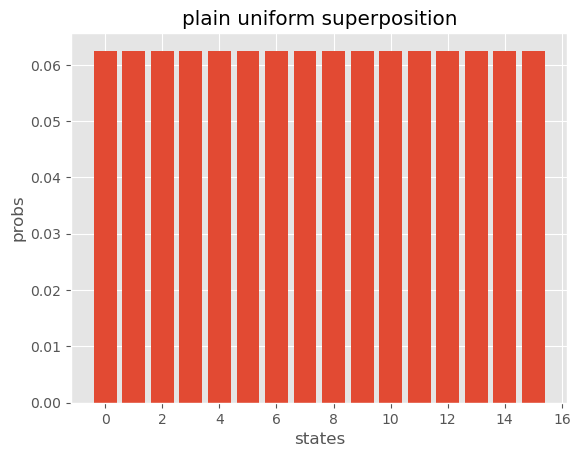

In [4]:
plt.style.use('ggplot')
plt.title("plain uniform superposition")
plt.xlabel("states")
plt.ylabel("probs")
plt.bar(np.arange(16),naive_circuit())
plt.show()

## Module 2

In [5]:
def oracle_matrix(combo):
    """Return the oracle matrix for a secret combination.
    
    Args:
        combo (list[int]): A list of bits representing a secret combination.
         
    Returns: 
        array[float]: The matrix representation of the oracle.
    """
    index = np.ravel_multi_index(combo, [2]*len(combo)) # Index of solution
    my_array = np.identity(2**len(combo)) # Create the identity matrix

    ##################
    # YOUR CODE HERE #
    ##################

    # MODIFY DIAGONAL ENTRY CORRESPONDING TO SOLUTION INDEX
    w = np.zeros(2**len(combo))
    w[index] = -1
    my_array = my_array - 2*np.outer(w,w)
    return my_array

In [6]:
oracle_matrix([0,1,0])

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]], requires_grad=True)

In [7]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def oracle_circuit(combo):
    """Create a uniform superposition, apply the oracle, and return probabilities.
    
    Args:
        combo (list[int]): A list of bits representing a secret combination.

    Returns:
        list[float]: The output probabilities.
    """

    ##################
    # YOUR CODE HERE #
    ##################
    for wire in range(n_bits): 
        qml.Hadamard(wire)
    qml.QubitUnitary(oracle_matrix(combo), wires = range(n_bits))
    return qml.probs(wires=range(n_bits))

In [8]:
oracle_circuit([0,0,1,0])

tensor([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625], requires_grad=True)

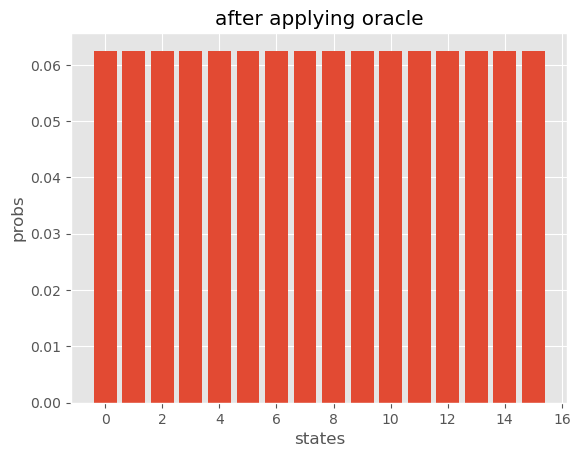

In [9]:
plt.style.use('ggplot')
plt.title("after applying oracle")
plt.xlabel("states")
plt.ylabel("probs")
plt.bar(np.arange(16),oracle_circuit([0,0,1,0]))
plt.show()

## Module 3

In [10]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def pair_circuit(x_tilde, combo):
    """Test a pair labelled by x_tilde for the presence of a solution.
    
    Args:
        x_tilde (list[int]): An (n_bits - 1)-string labelling the pair to test.
        combo (list[int]): A secret combination of n_bits 0s and 1s.
        
    Returns:
        array[float]: Probabilities on the last qubit.
    """
    for i in range(n_bits-1): # Initialize x_tilde part of state
        if x_tilde[i] == 1:
            qml.PauliX(wires=i)

    ##################
    # YOUR CODE HERE #
    ##################
    qml.Hadamard(n_bits-1)
    qml.QubitUnitary(oracle_matrix(combo), wires = range(n_bits))
    qml.Hadamard(n_bits-1)
    return qml.probs(wires=n_bits-1)

In [14]:
def secret_combo(n):
    return np.random.choice([0,1],n)

In [15]:
def pair_lock_picker(trials):
    """Create a combo, run pair_circuit until it succeeds, and tally success rate.
    
    Args:
        trials (int): Number of times to test the lock picker.

    Returns:
        float: The average number of times the lock picker uses pair_circuit.
    """
    x_tilde_strs = [np.binary_repr(n, n_bits-1) for n in range(2**(n_bits-1))]
    x_tildes = [[int(s) for s in x_tilde_str] for x_tilde_str in x_tilde_strs] 

    test_numbers = []
    for trial in range(trials):
        combo = secret_combo(n_bits) # Random list of bits
        counter = 0
        for x_tilde in x_tildes:
            counter += 1

            ##################
            # YOUR CODE HERE #
            ##################
            if np.isclose(pair_circuit(x_tilde,combo)[1],1):
                break
        test_numbers.append(counter)
    return sum(test_numbers)/trials

trials = 500
output = pair_lock_picker(trials)

print(f"For {n_bits} bits, it takes", output, "pair tests on average.")

For 4 bits, it takes 4.498 pair tests on average.


## Module 4

In [16]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

def multisol_oracle_matrix(combos):
    my_array = np.identity(2 ** n_bits)
    
    indices = [np.ravel_multi_index(combo, [2]*len(combo)) for combo in combos]
    for i in range(len(combos)):
        my_array[indices[i], indices[i]] = -1
    return my_array
    pass

@qml.qnode(dev)
def multisol_pair_circuit(x_tilde, combos):
    for i in range(n_bits-1): # Initialize x_tilde part of state
        if x_tilde[i] == 1:
            qml.PauliX(wires=i)
    #Apply circuit
    qml.Hadamard(wires = n_bits-1)
    qml.QubitUnitary(multisol_oracle_matrix(combos), wires = list(range(n_bits)))
    qml.Hadamard(wires = n_bits-1)
    return qml.probs(wires=n_bits-1)

In [17]:
def parity_checker(combos):
    parity = 0
    counter = 0
    x_tilde_strs = [np.binary_repr(n, n_bits-1) for n in range(2**(n_bits-1))]
    x_tildes = [[int(s) for s in x_tilde_str] for x_tilde_str in x_tilde_strs]
    
    for x_tilde in x_tildes:
        if np.isclose(multisol_pair_circuit(x_tilde, combos)[1], 1):
            counter += 1
            
    parity = counter % 2
    return parity

## Module 5

In [18]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def hoh_circuit(combo):
    qml.broadcast(qml.Hadamard, wires = list(range(n_bits)), pattern = "single")
    
    qml.QubitUnitary(oracle_matrix(combo), wires = list(range(n_bits)))
    
    qml.broadcast(qml.Hadamard, wires = list(range(n_bits)), pattern = "single")

    return qml.probs(wires=range(n_bits))

## Module 6

In [19]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def multisol_hoh_circuit(combos):

    qml.broadcast(qml.Hadamard, wires = list(range(n_bits)), pattern = "single")
    
    qml.QubitUnitary(multisol_oracle_matrix(combos), wires = list(range(n_bits)))
    
    qml.broadcast(qml.Hadamard, wires = list(range(n_bits)), pattern = "single")

    return qml.probs(wires=range(n_bits))

In [20]:
def deutsch_jozsa(promise_var):
    if promise_var == 0:
        how_many = 2**(n_bits - 1)
    else:
        how_many = np.random.choice([0, 2**n_bits]) # Choose all or nothing randomly
    combos = multisol_combo(n_bits, how_many) # Generate random combinations

    #Use multisol function to run the Deutsch-Josza circuit, return the value corresponding to a balanced or constant function
    if np.isclose(multisol_hoh_circuit(combos)[0],0):
        return 0
    else:
        return 1
